In [ ]:
pip install cvxpylayers

     |████████████████████████████████| 5.2 MB 40.6 MB/s 
     |████████████████████████████████| 2.8 MB 42.4 MB/s 
     |████████████████████████████████| 213 kB 66.2 MB/s 
  Created wheel for cvxpylayers: filename=cvxpylayers-0.1.5-py3-none-any.whl size=26081 sha256=49ee77acf9ab6401e0ca8ed1963815bf4dc15564e5638f4b44b6b575baf9188c
  Stored in directory: /root/.cache/pip/wheels/ce/39/00/c15a6af7421539feb1befa0e5a79e11e16b720848b7d2bfff7
Successfully built cvxpylayers
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-1.0.31:
      Successfully uninstalled cvxpy-1.0.31


In [27]:
import cvxpy as cp
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import math
import time
#from cvxpylayers.torch import CvxpyLayer

class Soft_Landing_Convex_Problem:
    def __init__(self, T_max=24000, m_0 = 2000, m_f = 300, rho_1 = 0.2, rho_2 = 0.8, alpha = 5e-4, n_idx = 50, tf = 60, w_idx = 5):
        # Define some standard matrices
        self._eye3 = np.array([[1],[1],[1]])

        # Define the following properties:
        self._m_0 = m_0 # initial mass [kg]
        self._m_f = m_f  # final   mass [kg]

        self._T_max = T_max # Max Thrust [N]
        self._rho_1 = rho_1 * T_max # Lower Thrust Limit
        self._rho_2 = rho_2 * T_max # Upper Thrust Limit

        self._alpha = alpha # fuel consumption rate [s/m]

        self._theta = 45 * np.pi / 180 # max thrust angle constraint [rad]

        self._r_0 = np.array([2400, 450, -330]) # Initial Position

        self._dr_0 = np.array([-10, -40, 10]) # Initial Velocity
        self._x_state = np.concatenate([self._r_0, self._dr_0]) # State Vector

        self._q = np.array([0, 0]) # target landing site in guidance frame [m]
        self._q2 = np.array([0, 0, 0]) # target landing site in guidance frame [m], including altitude
        self._g = np.array([-3.71, 0, 0]) # Mars constant gravity vector [m/s^2]
        self._w = np.array([2.53e-5, 0, 6.62e-5]) # Mars constant rotational velocity [rad/s]

        # Define the S matrix
        self._S_w = np.array([[ 0, -self._w[2], self._w[1]],
                        [ self._w[2], 0, -self._w[1]],
                        [-self._w[1], self._w[0], 0]])

        # Construct the A matrix
        self._A_w_top = np.concatenate([np.zeros([3,3]), np.eye(3)], 1)
        self._A_w_bot = np.concatenate( [-np.power(self._S_w,2), -2 * self._S_w], 1 )
        self._A_w = np.concatenate( [self._A_w_top, self._A_w_bot], 0 )

        # Construct the B matrix
        self._B = np.concatenate([np.zeros([3,3]), np.eye(3)])

        # Define the E matrix
        self._e1 = np.array([1, 0, 0]) 
        self._e2 = np.array([0, 1, 0]) 
        self._e3 = np.array([0, 0, 1]) 
        self._E = np.concatenate([[self._e2],[self._e3]], axis=0)

        # Define the body axis variable which the thrust vector is constrained against
        self._n_hat = np.array([1,0,0]) # Likely correct

        # Glide Constraints
        self._theta = 45 * np.pi / 180 # max thrust angle constraint [rad]
        self._gamma_gs = 30 * np.pi / 180 # glide constraint [rad]

        #self._c = e1 / np.tan(gamma_gs)

        # Velocity Constraints
        self._V_max = 100 # m/s

        # Define and solve the CVXPY problem.
        self._n_idx = n_idx # number of timesteps
        self._tf = tf  # final time [s]
        self._w_idx = w_idx # Timesteps between critic parameter updates

        self._tstep = tf / self._n_idx

        # Create a time vector from 0 to tf with n intervals
        self._ts, self._delt = np.linspace(0,self._tf,self._n_idx,endpoint=True,retstep=True)

        # Create a state noise vector
        #self._state_noise = np.random.normal(mu, sigma1, [self._n_idx, 6])

        self._g = np.array([-3.71, 0, 0]) # Mars constant gravity vector [m/s^2]
        self._w = np.array([2.53e-5, 0, 6.62e-5]) # Mars constant rotational velocity [rad/s]
        self._optimal_x_t = None

    def initialize_variables(self, n_idx):
        # Define the optimization variables
        x_t  = cp.Variable([6,n_idx+1]) # State time history
        dx_t = cp.Variable([6,n_idx]) # State Derivative time history
        T_c  = cp.Variable([3,n_idx]) # Thrust Vector time history
        m_t  = cp.Variable([1,n_idx+1]) # Mass time history
        dm_t = cp.Variable([1,n_idx])   # Mass Flow time history

        # Define the slack variable
        Gamma_t = cp.Variable([1,n_idx])   # Mass Flow time history

        # Define the Convex Relaxed Minimum Landing Error Problem 
        sigma_t = cp.Variable([1,n_idx]) # Slack Variable    sigma(t) = Gamma(t) / m(t)
        u_t = cp.Variable([3,n_idx])     # Slack Variable    u(t)     = T(t) / m(t)
        z_t = cp.Variable([1,n_idx+1])   # Slack Variable    z(t)     = ln(m(t))
        dz_t = cp.Variable([1,n_idx])   # Slack Variable     dz(t)    = dm(t) / m(t)
        z_0 = np.log(self._m_0 - self._alpha * self._rho_2 * self._ts)

        return x_t, dx_t, sigma_t, u_t, z_t, dz_t, z_0

    def add_noise(self):
        #self._g = np.array([-3.71, 0, 0]) # Mars constant gravity vector [m/s^2]
        #self._w = np.array([2.53e-5, 0, 6.62e-5]) # Mars constant rotational velocity [rad/s]

        # Define noise vectors to just be 1% of the gravity magnitude
        self._g_noise = np.random.rand(3) * np.power(0.01 * np.linalg.norm(self._g), 2)
        self._w_noise = np.random.rand(3) * np.power(0.01 * np.linalg.norm(self._w), 2)

        # Add noise to the environment
        self._g = self._g + self._g_noise # Mars constant gravity vector [m/s^2]
        self._w = self._w + self._w_noise # Mars constant rotational velocity [rad/s]

        self._S_w = np.array([[ 0, -self._w[2], self._w[1]],
                            [ self._w[2], 0, -self._w[1]],
                            [-self._w[1], self._w[0], 0]])

    def get_optimal_obj_and_constraint(self, x_t_dt, dx_t_dt, z_t_dt, dz_t_dt, u_t_dt, sigma_t_dt, r_0_dt, dr_0_dt, m_0_dt, z_0_dt, n):
        g = self._g
        w = self._w

        # Recalculate the S matrix
        S_w = np.array([[ 0, -w[2], w[1]],
                        [ w[2], 0, -w[1]],
                        [-w[1], w[0], 0]])

        # Recalculate the A matrix
        A_w_top = np.concatenate([np.zeros([3,3]), np.eye(3)], 1)
        A_w_bot = np.concatenate( [-np.power(S_w, 2), -2 * S_w], 1 )
        A_w = np.concatenate( [A_w_top, A_w_bot], 0 )

        # Define the state estimation noise
        #pos_noise = np.random.randn(3, n) * 0.1  * 0
        #vel_noise = np.random.randn(3, n) * 0.01 * 0
        #state_noise = np.concatenate([pos_noise, vel_noise])

        # Define the objective function
        min_land_err_obj  = cp.Minimize(cp.norm( self._E @ x_t_dt[0:2+1,-1] - self._q ))

        # Define the constraint
        min_land_err_const = [
                          x_t_dt[0:2+1,0] == r_0_dt,                                    # (8)
                          x_t_dt[3:5+1,0] == dr_0_dt,                                   # (8)
                          cp.multiply(self._e1, x_t_dt[0:2+1,-1]) == 0,                       # (9)
                          x_t_dt[3:5+1,-1] == 0,                                        # (9) 
                          #dx_t_dt == A_w * x_t_dt[:,0:n] + B * (np.matlib.repmat(g.T, n, 1).T + u_t_dt ) + state_noise, # (17) 
                          dx_t_dt == A_w @ x_t_dt[:,0:n] + self._B @ (np.matlib.repmat(g.T, n, 1).T + u_t_dt ), # (17) 
                          x_t_dt[:,1:n+1] == x_t_dt[:,0:n] + dx_t_dt * self._tstep,                # Need to update the position and velocity based on the change in states
                          # Slack variable substitute to resolve T(t)/m(t) nonconvexity
                          # Revised mass flow constraints
                          z_t_dt[0,0] == np.log(m_0_dt),                                   # (7)
                          z_t_dt >= np.log(self._m_f),                                        # (7)
                          dz_t_dt[0,:] == -self._alpha * sigma_t_dt[0,0:n],                      # (33)
                          z_t_dt[0,1:n+1] == z_t_dt[0,0:n] + dz_t_dt[0,:] * self._tstep,            # Need to update the mass based on the change in states

                          cp.norm(u_t_dt, axis=0) <= sigma_t_dt[0,:],                      # (34)
                          self._n_hat @ u_t_dt >= np.cos(self._theta) * sigma_t_dt[0,:],               # (34)

                          # Revised control constraints
                          self._rho_1 * np.exp(-z_0_dt[0])* ((1 - (z_t_dt[0,0:n] - z_0_dt)) + cp.power((z_t_dt[0,0:n] - z_0_dt),2) / 2) <= sigma_t_dt[0,:],
                          sigma_t_dt[0,:] <= self._rho_2 * np.exp(-z_0_dt[0]) * (1 - (z_t_dt[0,0:n] - z_0_dt)),

                          ]       # (19)

        return min_land_err_obj, min_land_err_const

    def get_obj_and_constraint(self, x_t_dt, dx_t_dt, z_t_dt, dz_t_dt, u_t_dt, sigma_t_dt, r_0_dt, dr_0_dt, m_0_dt, z_0_dt, n):
   
        # Define the environment
        #self._g = np.array([-3.71, 0, 0]) # Mars constant gravity vector [m/s^2]
        #self._w = np.array([2.53e-5, 0, 6.62e-5]) # Mars constant rotational velocity [rad/s]

        # Define the environment noise
        g_noise = np.random.randn(3) * np.linalg.norm(self._g) * 0.01 * 0
        w_noise = np.random.randn(3) * np.linalg.norm(self._w) * 0.01 * 0

        # Add noise to the environment
        # self._g = self._g + self._g_noise # Mars constant gravity vector [m/s^2]
        # self._w = self._w + self._w_noise # Mars constant rotational velocity [rad/s]

        g = self._g + g_noise        
        w = self._w + w_noise

        # Recalculate the S matrix
        S_w = np.array([[ 0, -w[2], w[1]],
                        [ w[2], 0, -w[1]],
                        [-w[1], w[0], 0]])

        # Recalculate the A matrix
        A_w_top = np.concatenate([np.zeros([3,3]), np.eye(3)], 1)
        A_w_bot = np.concatenate( [-np.power(S_w, 2), -2 * S_w], 1 )
        A_w = np.concatenate( [A_w_top, A_w_bot], 0 )

        # Define the state estimation noise
        #pos_noise = np.random.randn(3, n) * 0.1  * 0
        #vel_noise = np.random.randn(3, n) * 0.01 * 0
        #state_noise = np.concatenate([pos_noise, vel_noise])

        # Define the objective function
        min_land_err_obj  = cp.Minimize(cp.norm( self._E @ x_t_dt[0:2+1,-1] - self._q ))
        
        # Define the constraint
        min_land_err_const = [
                          x_t_dt[0:2+1,0] == r_0_dt,                                    # (8)
                          x_t_dt[3:5+1,0] == dr_0_dt,                                   # (8)
                          cp.multiply(self._e1, x_t_dt[0:2+1,-1]) == 0,                       # (9)
                          x_t_dt[3:5+1,-1] == 0,                                        # (9) 
                          #dx_t_dt == A_w * x_t_dt[:,0:n] + B * (np.matlib.repmat(g.T, n, 1).T + u_t_dt ) + state_noise, # (17) 
                          dx_t_dt == A_w @ x_t_dt[:,0:n] + self._B @ (np.matlib.repmat(g.T, n, 1).T + u_t_dt ), # (17) 
                          x_t_dt[:,1:n+1] == x_t_dt[:,0:n] + dx_t_dt * self._tstep,                # Need to update the position and velocity based on the change in states
                          # Slack variable substitute to resolve T(t)/m(t) nonconvexity
                          # Revised mass flow constraints
                          z_t_dt[0,0] == np.log(m_0_dt),                                   # (7)
                          z_t_dt >= np.log(self._m_f),                                        # (7)
                          dz_t_dt[0,:] == -self._alpha * sigma_t_dt[0,0:n],                      # (33)
                          z_t_dt[0,1:n+1] == z_t_dt[0,0:n] + dz_t_dt[0,:] * self._tstep,            # Need to update the mass based on the change in states

                          cp.norm(u_t_dt, axis=0) <= sigma_t_dt[0,:],                      # (34)
                          self._n_hat @ u_t_dt >= np.cos(self._theta) * sigma_t_dt[0,:],               # (34)

                          # Revised control constraints
                          self._rho_1 * np.exp(-z_0_dt[0]) * ((1 - (z_t_dt[0,0:n] - z_0_dt)) + cp.power((z_t_dt[0,0:n] - z_0_dt),2) / 2) <= sigma_t_dt[0,:],
                          sigma_t_dt[0,:] <= self._rho_2 * np.exp(-z_0_dt[0]) * (1 - (z_t_dt[0,0:n] - z_0_dt)),

                          ]       # (19)

        return min_land_err_obj, min_land_err_const

    def get_critic_obj_and_constraint(self, x_t_dt, dx_t_dt, z_t_dt, dz_t_dt, u_t_dt, sigma_t_dt, r_0_dt, dr_0_dt, m_0_dt, z_0_dt, n, state_noise):
        
        # Define the environment
        #g = np.array([-3.71, 0, 0]) # Mars constant gravity vector [m/s^2]
        #w = np.array([2.53e-5, 0, 6.62e-5]) # Mars constant rotational velocity [rad/s]

        # Define the environment noise
        g_noise = np.random.randn(3) * np.linalg.norm(self._g) * 0.01 * 0
        w_noise = np.random.randn(3) * np.linalg.norm(self._w) * 0.01 * 0

        # Add noise to the environment
        g = self._g + g_noise # Mars constant gravity vector [m/s^2]
        w = self._w + w_noise # Mars constant rotational velocity [rad/s]

        # Recalculate the S matrix
        S_w = np.array([[ 0, -w[2], w[1]],
                        [ w[2], 0, -w[1]],
                        [-w[1], w[0], 0]])

        # Recalculate the A matrix
        A_w_top = np.concatenate([np.zeros([3,3]), np.eye(3)], 1)
        A_w_bot = np.concatenate( [-np.power(S_w,2), -2 * S_w], 1 )
        A_w = np.concatenate( [A_w_top, A_w_bot], 0 )

        # Define the state estimation noise

        # Define the objective function
        min_land_err_obj  = cp.Minimize(cp.norm( self._E @ x_t_dt[0:2+1,-1] - self._q ))

        # Define the constraint
        min_land_err_const = [
                          x_t_dt[0:2+1,0] == r_0_dt,                                    # (8)
                          x_t_dt[3:5+1,0] == dr_0_dt,                                   # (8)
                          cp.multiply(self._e1, x_t_dt[0:2+1,-1]) == 0,                       # (9)
                          x_t_dt[3:5+1,-1] == 0,                                        # (9) 
                          dx_t_dt == self._A_w @ x_t_dt[:,0:n] + self._B @ (np.matlib.repmat(g.T, n, 1).T + u_t_dt ),# + state_noise, # (17) 
                          x_t_dt[:,1:n+1] == x_t_dt[:,0:n] + dx_t_dt * self._tstep,                # Need to update the position and velocity based on the change in states                      
                          # Slack variable substitute to resolve T(t)/m(t) nonconvexity
                          # Revised mass flow constraints
                          z_t_dt[0,0] == np.log(m_0_dt),                                   # (7)
                          z_t_dt >= np.log(self._m_f),                                        # (7)
                          dz_t_dt[0,:] == -self._alpha * sigma_t_dt[0,0:n],                      # (33)
                          z_t_dt[0,1:n+1] == z_t_dt[0,0:n] + dz_t_dt[0,:] * self._tstep,            # Need to update the mass based on the change in states

                          cp.norm(u_t_dt, axis=0) <= sigma_t_dt[0,:],                      # (34)
                          self._n_hat @ u_t_dt >= np.cos(self._theta) * sigma_t_dt[0,:],               # (34)

                          # Revised control constraints
                          self._rho_1 * np.exp(-z_0_dt[0]) * ((1 - (z_t_dt[0,0:n] - z_0_dt)) + cp.power((z_t_dt[0,0:n] - z_0_dt),2) / 2) <= sigma_t_dt[0,:],
                          sigma_t_dt[0,:] <= self._rho_2 * np.exp(-z_0_dt[0]) * (1 - (z_t_dt[0,0:n] - z_0_dt)),

                          ]       # (19)

        return min_land_err_obj, min_land_err_const

    def compute_optimal(self):
        x_t, dx_t, sigma_t, u_t, z_t, dz_t, z_0 = self.initialize_variables(self._n_idx)

        min_land_err_obj, min_land_err_const = self.get_optimal_obj_and_constraint(x_t, dx_t, z_t, dz_t, u_t, sigma_t, self._r_0, self._dr_0, self._m_0, z_0, self._n_idx)
        min_land_err_prob = cp.Problem(min_land_err_obj, min_land_err_const)

        # Solve the convex problem
        min_land_err_prob.solve()  # Returns the optimal value.

        self._optimal_x_t = x_t.value

    def compute_noise(self, state_noise):
        n = self._n_idx

        # Initialize the convex optimization variables
        x_t, dx_t, sigma_t, u_t, z_t, dz_t, z_0 = self.initialize_variables(self._n_idx)

        # Initialize the loggers
        #self._x_t_hist = np.zeros([n_idx, 6, n_idx])
        #self._z_t_hist = np.zeros([n_idx, 1, n_idx])
        #self._u_t_hist = np.zeros([n_idx, 3, n_idx])
        #self._t_hist   = np.zeros([n_idx, 1, n_idx])
        #self._c_buff = np.zeros([w_idx,3])

        # Recalculate the convex problem for each time step
        # Note: Convex problem cannot be solved when the array size is less than 3
        for t_idx in range(self._n_idx - 1):
          x_t_dt  = x_t
          dx_t_dt = dx_t
          z_t_dt  = z_t
          dz_t_dt = dz_t
          u_t_dt = u_t
          sigma_t_dt = sigma_t
          z_0_dt = z_0

          if (t_idx == 0):
            r_0_dt = self._r_0
            dr_0_dt = self._dr_0
            m_0_dt = self._m_0
          else:
            r_0_dt = x_t_dt[0:2+1,0].value + state_noise[t_idx, 0:3] 
            dr_0_dt = x_t_dt[3:5+1,0].value + state_noise[t_idx, 3:6] 
            m_0_dt = np.exp(z_t[0,0].value)

          # Define the constraints and define the problem
          min_land_err_obj, min_land_err_const = self.get_obj_and_constraint(x_t_dt, dx_t_dt, z_t_dt, dz_t_dt, u_t_dt, sigma_t_dt, r_0_dt, dr_0_dt, m_0_dt, z_0_dt, n)
          min_land_err_prob = cp.Problem(min_land_err_obj, min_land_err_const)

          # Solve the convex problem
          min_land_err_prob.solve()  # Returns the optimal value.
        
          # Log the solution at each step
          #self._x_t_hist[t_idx,:,0:n] = x_t.value[:,0:n]
          #self._z_t_hist[t_idx,:,0:n] = z_t.value[:,0:n]
          #self._u_t_hist[t_idx,:,0:n] = u_t.value[:,0:n]
          #self._t_hist[t_idx,:,0:n]   = self._ts[self._n_idx-n:self._n_idx]

          # Update Step
          x_t = x_t_dt[:,1:]
          dx_t = dx_t_dt[:,1:]
          z_t = z_t_dt[:,1:]
          dz_t = dz_t_dt[:,1:]
          u_t = u_t_dt[:,1:]
          sigma_t = sigma_t_dt[:,1:]
          z_0 = z_0_dt[1:]

          self._noise_x_t[:, t_idx] = x_t[:,0].value
          n -= 1

    def compute_critic_noise1(self, state_noise):
        n = self._n_idx

        # Initialize the convex optimization variables
        x_t, dx_t, sigma_t, u_t, z_t, dz_t, z_0 = self.initialize_variables(self._n_idx)
        adjustment = np.zeros([6])

        # Initialize the loggers
        #self._x_t_hist = np.zeros([n_idx, 6, n_idx])
        #self._z_t_hist = np.zeros([n_idx, 1, n_idx])
        #self._u_t_hist = np.zeros([n_idx, 3, n_idx])
        #self._t_hist   = np.zeros([n_idx, 1, n_idx])
        #self._c_buff = np.zeros([w_idx,3])

        # Recalculate the convex problem for each time step
        # Note: Convex problem cannot be solved when the array size is less than 3
        for t_idx in range(self._n_idx - 1):
          x_t_dt  = x_t
          dx_t_dt = dx_t
          z_t_dt  = z_t
          dz_t_dt = dz_t
          u_t_dt = u_t
          sigma_t_dt = sigma_t
          z_0_dt = z_0

          if (t_idx == 0):
            r_0_dt = self._r_0
            dr_0_dt = self._dr_0
            m_0_dt = self._m_0
          else:
            r_0_dt = x_t_dt[0:2+1,0].value + state_noise[t_idx, 0:3] - adjustment[0:3] 
            dr_0_dt = x_t_dt[3:5+1,0].value + state_noise[t_idx, 3:6] - adjustment[3:6] 
            m_0_dt = np.exp(z_t[0,0].value)

          # Define the constraints and define the problem
          min_land_err_obj, min_land_err_const = self.get_obj_and_constraint(x_t_dt, dx_t_dt, z_t_dt, dz_t_dt, u_t_dt, sigma_t_dt, r_0_dt, dr_0_dt, m_0_dt, z_0_dt, n)
          min_land_err_prob = cp.Problem(min_land_err_obj, min_land_err_const)

          # Solve the convex problem
          min_land_err_prob.solve()  # Returns the optimal value.
        
          # Log the solution at each step
          #self._x_t_hist[t_idx,:,0:n] = x_t.value[:,0:n]
          #self._z_t_hist[t_idx,:,0:n] = z_t.value[:,0:n]
          #self._u_t_hist[t_idx,:,0:n] = u_t.value[:,0:n]
          #self._t_hist[t_idx,:,0:n]   = self._ts[self._n_idx-n:self._n_idx]

          # Update Step
          x_t = x_t_dt[:,1:]
          dx_t = dx_t_dt[:,1:]
          z_t = z_t_dt[:,1:]
          dz_t = dz_t_dt[:,1:]
          u_t = u_t_dt[:,1:]
          sigma_t = sigma_t_dt[:,1:]
          z_0 = z_0_dt[1:]

          self._critic_noise1_x_t[:, t_idx] = x_t[:,0].value

          if ((t_idx % self._w_idx) == 0 and t_idx > 0):
            # update adjustment variables
            adjustment = self.compute_adjustment(t_idx)
            print(adjustment)
          self._adjusment_hist[:,t_idx] = adjustment

          n -= 1

    def compute_adjustment(self, t_idx):
        #np.mean(S._noise_x_t[:,0:10],axis=1).shape
        if (t_idx < self._n_idx - 4):
          noise1 = np.add(np.subtract(self._critic_noise_x_t[:,0:t_idx],self._optimal_x_t[:,0:t_idx]), self._adjusment_hist[:,0:t_idx])
          mean1 = np.mean(noise1, axis=1) * .5
        else:
          mean1 = 0

        return mean1

    def calc_cost(self, x_t, r_0):
      new_x = x_t[0]
      new_y = x_t[1]
      new_z = x_t[2]
      return [abs(new_x-r_0[0]), abs(new_y-r_0[1]), abs(new_z-r_0[2])]

    def calc_cost2(self, x_t, r_0):
      # Calculates the Euclidean distance of current position from destination.
      delta = np.subtract(x_t, r_0)
      deltaSqr = np.square(delta)
      deltaSum = np.sum(deltaSqr)
      distance = math.sqrt(deltaSum)
      return distance

    def least_squares(self, expected, actual):
        # Finds the minimum value of 
        # sum(||actual - expected * upper triagonal array * w - actual * lower triagonal array||)
        # expected: a list or a vector of numbers
        # actual: a list or a vector of numbers
        # returns the argument minimum and the minimum value of the solution    
        if type(expected) is list:
          expected = np.array(expected)
        if type(actual) is list:
          actual = np.array(actual)
        expected_shape = expected.shape
        actual_shape = actual.shape
        if expected_shape != actual_shape:
          raise ValueError("Error: Parameter expected and actual need to be the same shape")
        if len(expected_shape) == 1:
          expected_length = expected_shape[0]
        elif len(expected_shape) == 2:
          if expected_shape[0] != 1 or expected_shape[1] != 1:
            raise ValueError("Error: Parameters must be vectors")
          else:
            expected_length = len(expected)
        else:
            raise ValueError("Error: too many dimensions")

        if expected_length < 1:
          raise ValueError("Error: the length must be greater than 1")

        upper1=np.zeros((expected_length, expected_length))
        upper1[np.triu_indices(expected_length, 0)] = 1
        lower1=np.zeros((expected_length, expected_length))
        lower1[np.triu_indices(expected_length, 1)] = 1
        lower1 = lower1.T

        expected_matrix = np.reshape(np.repeat(expected, expected_length), [expected_length, expected_length]).T
        actual_matrix = np.reshape(np.repeat(actual, expected_length), [expected_length, expected_length]).T

        w  = cp.Variable([1])
        f1 = cp.sum(cp.square(actual - cp.sum(cp.multiply(actual_matrix, lower1) + cp.multiply(expected_matrix, upper1) * w, axis=1)))
        min_f1  = cp.Minimize(f1)
        prob1=cp.Problem(min_f1)
        min_value = prob1.solve()

        if len(w.value.shape) == 1 and w.value.shape[0] == 1:
          arg_min = w.value[0]
        else:
          arg_min = w.value

        q_estimate = np.square(actual - np.sum(np.multiply(actual_matrix, lower1) + np.multiply(expected_matrix, upper1) * arg_min, axis=1))

        return [arg_min, min_value, q_estimate]

    def reward_warping(self, c_buff, rwf_w):
      return (rwf_w*np.sum(c_buff))

    def estimate_Q(self, crit_state, crit_rwf):
      pass

    def adapt_parameters(self, crit_estimate,crit_z):
      temp = crit_z - 0.05
      return temp

    def compute_critic_noise2(self, state_noise):
      # Initialize the index
      n = self._n_idx

      # Initialize the convex optimization variables
      x_t, dx_t, sigma_t, u_t, z_t, dz_t, z_0 = self.initialize_variables(self._n_idx)

      # Initialize the loggers
      x_t_hist = np.zeros([self._n_idx, 6, self._n_idx])
      z_t_hist = np.zeros([self._n_idx, 1, self._n_idx])
      u_t_hist = np.zeros([self._n_idx, 3, self._n_idx])
      t_hist   = np.zeros([self._n_idx, 1, self._n_idx])
      c_buff = np.zeros([self._w_idx, 3])

      # Initializes parameters
      rwf_w = 0.1 # Critic Parameter

      # Recalculate the convex problem for each time step
      # Note: Convex problem cannot be solved when the array size is less than 3
      for t_idx in range(self._n_idx - 1):
        # 
        x_t_dt  = x_t
        dx_t_dt = dx_t
        z_t_dt  = z_t
        dz_t_dt = dz_t
        u_t_dt = u_t
        sigma_t_dt = sigma_t
        z_0_dt = z_0

        if (t_idx == 0):
          r_0_dt = self._r_0
          dr_0_dt = self._dr_0
          m_0_dt = self._m_0
        else:
          r_0_dt = x_t_dt[0:2+1,0].value
          dr_0_dt = x_t_dt[3:5+1,0].value
          m_0_dt = np.exp(z_t[0,0].value)

        # Define the constraints and define the problem
        min_land_err_obj, min_land_err_const = self.get_critic_obj_and_constraint(x_t_dt, dx_t_dt, z_t_dt, dz_t_dt, u_t_dt, sigma_t_dt, r_0_dt, dr_0_dt, m_0_dt, z_0_dt, n, state_noise[t_idx])
        min_land_err_prob = cp.Problem(min_land_err_obj, min_land_err_const)

        # Solve the convex problem
        min_land_err_prob.solve()  # Returns the optimal value.

        # Log the solution at each step
        x_t_hist[t_idx,:,0:n] = x_t.value[:,0:n]
        z_t_hist[t_idx,:,0:n] = z_t.value[:,0:n]
        u_t_hist[t_idx,:,0:n] = u_t.value[:,0:n]
        t_hist[t_idx,:,0:n]   = self._ts[self._n_idx-n:self._n_idx]

        # Update Step
        x_t = x_t_dt[:,1:]
        dx_t = dx_t_dt[:,1:]
        z_t = z_t_dt[:,1:]
        dz_t = dz_t_dt[:,1:]
        u_t = u_t_dt[:,1:]
        sigma_t = sigma_t_dt[:,1:]
        z_0 = z_0_dt[1:]

        # Update Cost buffer
        c_buff[t_idx % self._w_idx] = self.calc_cost(x_t.value[0:3, 0], self._q2)

        n -= 1

        # Creates critic variables
        x_t_dt  = x_t
        dx_t_dt = dx_t
        z_t_dt  = z_t
        dz_t_dt = dz_t
        u_t_dt = u_t
        sigma_t_dt = sigma_t
        z_0_dt = z_0
        
        r_0_dt = x_t_dt[0:2+1,0].value
        dr_0_dt = x_t_dt[3:5+1,0].value
        m_0_dt = np.exp(z_t[0,0].value)
        # Define the constraints and define the problem
        crit_min_land_err_obj, crit_min_land_err_const = self.get_critic_obj_and_constraint(x_t_dt, dx_t_dt, z_t_dt, dz_t_dt, u_t_dt, sigma_t_dt, r_0_dt, dr_0_dt, m_0_dt, z_0_dt, n, state_noise[t_idx])
        crit_min_land_err_prob = cp.Problem(crit_min_land_err_obj, crit_min_land_err_const)
        crit_min_land_err_prob.solve()

        # Critic gets current state, rwf, and Q estimate
        crit_state = np.array([x_t.value[:,0:n][0][0], x_t.value[:,0:n][1][0], x_t.value[:,0:n][2][0]])
        crit_rwf = self.reward_warping(c_buff, rwf_w)
        crit_estimate = self.estimate_Q(crit_state, crit_rwf)
        # Updates critic every 5 steps
        if (t_idx % self._w_idx == 0):
          # Optimize Critic parameter
          crit_z = 1 # Optimizer variable
          rwf_w = self.adapt_parameters(crit_estimate, crit_z) # Placeholder

        self._critic_noise2_x_t[:, t_idx] = x_t[:,0].value

    def compute_critic_noise3(self, state_noise):
      # Initialize the index
      n = self._n_idx

      # Initialize the convex optimization variables
      x_t, dx_t, sigma_t, u_t, z_t, dz_t, z_0 = self.initialize_variables(self._n_idx)

      # Initialize the loggers
      x_t_hist = np.zeros([self._n_idx, 6, self._n_idx])
      z_t_hist = np.zeros([self._n_idx, 1, self._n_idx])
      u_t_hist = np.zeros([self._n_idx, 3, self._n_idx])
      t_hist   = np.zeros([self._n_idx, 1, self._n_idx])
      c_buff = np.zeros([self._w_idx])
      optimal_c_buff = np.zeros([self._w_idx])

      # Initializes parameters
      rwf_w = 0.1 # Critic Parameter
      optimal_update_flag = True

      # Recalculate the convex problem for each time step
      # Note: Convex problem cannot be solved when the array size is less than 3
      for t_idx in range(self._n_idx - 1):

        x_t_dt  = x_t
        dx_t_dt = dx_t
        z_t_dt  = z_t
        dz_t_dt = dz_t
        u_t_dt = u_t
        sigma_t_dt = sigma_t
        z_0_dt = z_0

        if (t_idx == 0):
          r_0_dt = self._r_0
          dr_0_dt = self._dr_0
          m_0_dt = self._m_0
        else:
          r_0_dt = x_t_dt[0:2+1,0].value
          dr_0_dt = x_t_dt[3:5+1,0].value
          m_0_dt = np.exp(z_t[0,0].value)

        if optimal_update_flag:
          optimal_update_flag = False
          optimal_x_t = x_t
          optimal_dx_t = dx_t
          optimal_z_t  = z_t
          optimal_dz_t = dz_t
          optimal_u_t = u_t
          optimal_sigma_t = sigma_t
          optimal_z_0 = z_0

          if (t_idx == 0):
            optimal_r_0_dt = self._r_0
            optimal_dr_0_dt = self._dr_0
            optimal_m_0_dt = self._m_0
          else:
            optimal_r_0_dt = x_t_dt[0:2+1,0].value
            optimal_dr_0_dt = x_t_dt[3:5+1,0].value
            optimal_m_0_dt = np.exp(z_t[0,0].value)

          optimal_min_land_err_obj, optimal_min_land_err_const = self.get_optimal_obj_and_constraint(optimal_x_t, optimal_dx_t, optimal_z_t, optimal_dz_t, optimal_u_t, optimal_sigma_t, optimal_r_0_dt, optimal_dr_0_dt, optimal_m_0_dt, optimal_z_0, n)
          optimal_min_land_err_prob = cp.Problem(optimal_min_land_err_obj, optimal_min_land_err_const)

          # Solve the convex problem
          optimal_min_land_err_prob.solve()  # Returns the optimal value.

          optimal_x_t_hist = optimal_x_t.value[:,0:n]
          optimal_z_t_hist = optimal_z_t.value[:,0:n]
          optimal_u_t_hist = optimal_u_t.value[:,0:n]

          # fill optimal_c_buff with optimal cost values
          if n > self._w_idx:
            buffer_length = self._w_idx
          else:
            buffer_length = n
          for c_index in range(0, buffer_length):
            optimal_c_buff[c_index] = self.calc_cost2(optimal_x_t_hist[0:3,c_index], self._q2)

        # Define the constraints and define the problem
        min_land_err_obj, min_land_err_const = self.get_critic_obj_and_constraint(x_t_dt, dx_t_dt, z_t_dt, dz_t_dt, u_t_dt, sigma_t_dt, r_0_dt, dr_0_dt, m_0_dt, z_0_dt, n, state_noise[t_idx])
        min_land_err_prob = cp.Problem(min_land_err_obj, min_land_err_const)
        # Solve the convex problem
        min_land_err_prob.solve(verbose=True)  # Returns the optimal value.

        # Update Cost buffer
        #c_buff[t_idx % self._w_idx] = self.calc_cost(x_t.value[:,0:n],self._q2)
        c_buff[t_idx % self._w_idx] = self.calc_cost2(x_t.value[0:3,0], self._q2)

        # Log the solution at each step
        x_t_hist[t_idx,:,0:n] = x_t.value[:,0:n]
        z_t_hist[t_idx,:,0:n] = z_t.value[:,0:n]
        u_t_hist[t_idx,:,0:n] = u_t.value[:,0:n]
        t_hist[t_idx,:,0:n]   = self._ts[self._n_idx-n:self._n_idx]

        # Update Step
        x_t = x_t_dt[:,1:]
        dx_t = dx_t_dt[:,1:]
        z_t = z_t_dt[:,1:]
        dz_t = dz_t_dt[:,1:]
        u_t = u_t_dt[:,1:]
        sigma_t = sigma_t_dt[:,1:]
        z_0 = z_0_dt[1:]
        n -= 1

        # Creates critic variables
        x_t_dt  = x_t
        dx_t_dt = dx_t
        z_t_dt  = z_t
        dz_t_dt = dz_t
        u_t_dt = u_t
        sigma_t_dt = sigma_t
        z_0_dt = z_0
        
        r_0_dt = x_t_dt[0:2+1,0].value
        dr_0_dt = x_t_dt[3:5+1,0].value
        m_0_dt = np.exp(z_t[0,0].value)
        # Define the constraints and define the problem
        crit_min_land_err_obj, crit_min_land_err_const = self.get_critic_obj_and_constraint(x_t_dt, dx_t_dt, z_t_dt, dz_t_dt, u_t_dt, sigma_t_dt, r_0_dt, dr_0_dt, m_0_dt, z_0_dt, n, state_noise[t_idx])
        crit_min_land_err_prob = cp.Problem(crit_min_land_err_obj, crit_min_land_err_const)
        crit_min_land_err_prob.solve(verbose=True)

        # Critic gets current state, rwf, and Q estimate
        crit_state = np.array([x_t.value[:,0:n][0][0], x_t.value[:,0:n][1][0], x_t.value[:,0:n][2][0]])
        crit_rwf = self.reward_warping(c_buff, rwf_w)
        crit_estimate = self.estimate_Q(crit_state, crit_rwf)
        # Updates critic every 5 steps
        if (t_idx % self._w_idx == 0 and t_idx != 0):
          optimal_update_flag = True
          # Optimize Critic parameter
          crit_z = 1 # Optimizer variable
          if n > self._w_idx:
            buffer_length = self._w_idx
          else:
            buffer_length = n
          [w, w_value, q_estimate] = self.least_squares(optimal_c_buff[0:buffer_length], c_buff[0:buffer_length])
          rwf_w = self.adapt_parameters(crit_estimate, crit_z) # Placeholder
          self._critic_noise3_w_t.append(w)

        self._critic_noise3_x_t[:, t_idx] = x_t[:,0].value

    def compute(self):
        # 1. Compute optimal trajectory with no noise. This is used as a comparison for the loss function.
        # 2. Compute trajectory with noise and no modification from the critic.
        # 3. Compute trajectory with modifications from the critic. Ideally its performance should be between the 2. The noise function will be exactly the same between 2 and 3.

        mu = 0
        sigma1 = 0.1

        self._adjusment_hist = np.zeros([6, self._n_idx + 1])
        state_noise = np.random.normal(mu, sigma1, [self._n_idx + 1, 6])

        self._noise_x_t = np.zeros([6, self._n_idx + 1])
        self._critic_noise1_x_t = np.zeros([6, self._n_idx + 1])
        self._critic_noise2_x_t = np.zeros([6, self._n_idx + 1])
        self._critic_noise3_x_t = np.zeros([6, self._n_idx + 1])
        self._critic_noise3_w_t = []
        self._optimal_x_t = None

        print ('Computing optimal')
        start_time = time.time()
        self.compute_optimal()
        end_time = time.time()
        print ('Elapsed time {0} seconds'.format(end_time - start_time))
        start_time = time.time()
        print ('Computing noise')
        self.compute_noise(state_noise)
        end_time = time.time()
        print ('Elapsed time {0} seconds'.format(end_time - start_time))
        start_time = time.time()
        print ('Computing critic noise2')
        self.compute_critic_noise2(state_noise)
        end_time = time.time()
        print ('Elapsed time {0} seconds'.format(end_time - start_time))
        start_time = time.time()
        print ('Computing critic noise3')
        self.compute_critic_noise3(state_noise)
        end_time = time.time()
        print ('Elapsed time {0} seconds'.format(end_time - start_time))
        

In [29]:
S = Soft_Landing_Convex_Problem(T_max=24000, m_0 = 2000, m_f = 300, rho_1 = 0.2, rho_2 = 0.8, alpha = 5e-4, n_idx = 50*4, tf = 60, w_idx = 5)
S.compute()

Computing optimal
Elapsed time 0.09511232376098633 seconds
Computing noise
Elapsed time 83.39685297012329 seconds
Computing critic noise2
Elapsed time 168.62664651870728 seconds
Computing critic noise3
Elapsed time 192.4631974697113 seconds


In [30]:
S._critic_noise3_w_t

[-0.09004508903855984,
 -0.09018467456361828,
 -0.09011751873259519,
 -0.09004401504008332,
 -0.08996402953742687,
 -0.0898773433731844,
 -0.08978364488926056,
 -0.08968252046732526,
 -0.089573442923503,
 -0.08945575749652039,
 -0.08932866415575362,
 -0.08919119624535642,
 -0.08904219358636174,
 -0.08888027022532259,
 -0.08870378010864317,
 -0.08851077354519948,
 -0.08829891474407842,
 -0.08806542761612271,
 -0.0878070189711061,
 -0.08751979278678973,
 -0.08719916761251983,
 -0.08683982945895244,
 -0.08643605891491289,
 -0.08598083184501487,
 -0.08546522580839365,
 -0.08487831520625048,
 -0.08420645205303255,
 -0.0834321519323996,
 -0.08253241635561326,
 -0.0814755117583533,
 -0.08021538562133598,
 -0.0786818704469846,
 -0.07676383660847555,
 -0.07427638813722222,
 -0.07089867669998241,
 -0.06601688747254715,
 -0.058293876267177955,
 -0.0441788320472978,
 0.06978275716506459]

Text(0.5, 0, 'epoch')

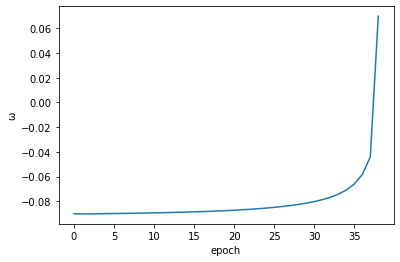

In [31]:
fig = plt.figure()
ax = plt.axes()
ax.plot(range(0, len(S._critic_noise3_w_t)), S._critic_noise3_w_t)
plt.ylabel('ω')
plt.xlabel('epoch')

In [32]:
def calculate_path_distance(path_list):
  path_list_shape = path_list.shape
  output_distance = np.zeros([path_list_shape[1]])  
  for index in range(0, path_list_shape[1] - 1):
    delta_distance = np.subtract(path_list[0:3, index + 1], path_list[0:3, index])
    delta_distance_sqr = np.square(delta_distance)    
    output_distance[index] = math.sqrt(np.sum(delta_distance_sqr))
  return output_distance

In [33]:
optimal_distance = calculate_path_distance(S._optimal_x_t)
noise_distance = calculate_path_distance(S._noise_x_t)
critic_noise2_distance = calculate_path_distance(S._critic_noise2_x_t)
critic_noise3_distance = calculate_path_distance(S._critic_noise3_x_t)

In [34]:
np.sum(noise_distance)

2700.164790267145

In [35]:
np.sum(optimal_distance)

2713.622745511022

In [36]:
np.sum(critic_noise2_distance)

2697.120678531361

In [37]:
np.sum(critic_noise3_distance)

2697.120678531361

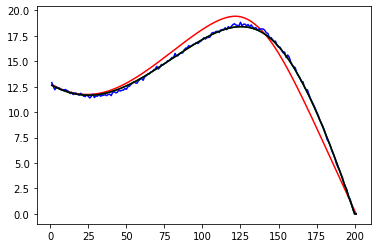

In [38]:
fig = plt.figure()
ax = plt.axes()
ax.plot(range(1,len(optimal_distance) + 1), optimal_distance, 'r', range(1,len(noise_distance) + 1), noise_distance, 'b', range(1,len(critic_noise2_distance) + 1), critic_noise2_distance, 'g', range(1,len(critic_noise3_distance) + 1), critic_noise3_distance, 'k')

Solution to the X State is


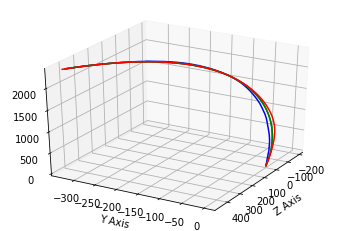

In [39]:
print("Solution to the X State is")
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(S._noise_x_t[1,:],  S._noise_x_t[2,:], S._noise_x_t[0,:],  'blue')
ax.plot3D(S._critic_noise2_x_t[1,:],  S._critic_noise2_x_t[2,:], S._critic_noise2_x_t[0,:],  'green')
ax.plot3D(S._critic_noise3_x_t[1,:],  S._critic_noise3_x_t[2,:], S._critic_noise3_x_t[0,:],  'green')
ax.plot3D(S._optimal_x_t[1,:],  S._optimal_x_t[2,:], S._optimal_x_t[0,:],  'red')
plt.ylabel('Y Axis')
plt.xlabel('Z Axis')
#plt.xlabel('X Axis')
ax.view_init(30, 30)